# Modules to be Installed
The following modules are required for this project:
- `os`
- `sys`
- `gmsh`
- `numpy` (`np`)
- `pandas` (`pd`)
- `pyvista` (`pv`)
- `matplotlib.pyplot` (`plt`)
- `math`
- `meshio`
- `gmshparser`
- `importlib`
- `shapely.geometry` (`Polygon`)
- `fortranformat`
- `datetime`
- `collections`
- `warnings`
- `scipy`
- `copy`
- `glob`
- `itertools`
- `functools`
- `time`
- `subprocess`
- `platform`
- `fortranformat`
- `shutil`
```markdown
To install these modules, use the following pip command:

```bash
pip install numpy pandas matplotlib scipy seaborn gmsh pyvista meshio gmshparser shapely fortranformat


```

# Predicting 2 D water and heat fluxes from temperature measurements and differential pressure

We will use `ginette` to predict streambed discharge from temperature measurements in real time. In particular, the class `tempest1d.EKF` provides an extended Kalman filter. Here's an example.

You can find the `ginette` repository on GitHub: [ginette GitHub Repository](https://github.com/agnes-riviere/ginette)

Ginette models temperature by solving a two-dimensional, unsaturated and fully saturated form of the hydrologic energy transport equation [1]. In three dimensions, the equation is

$\frac{d}{dt} \left( \left[\phi {C}_w + \left( 1-\phi \right) {C}_{sed} \right] T \right) = \nabla \cdot \left( \lambda \nabla T \right) - \nabla \cdot \left( \phi {C}_w \vec{v} T \right)$,

where 
$t$ is time in s,
$\phi$ is porosity (a unitless fraction of total volume),
${C}_w$ is the volumetric specific heat capacity of water in J/m$^3$&deg;C,
${C}_{sed}$ is the volumetric specific heat capacity of the dry sediments in J/m$^3$&deg;C,
$T$ is temperature in &deg;C,
$\lambda$ is the thermal conductivity of the porous media in W/m&deg;C (4 models are available to take account ice, water, solid and air),
and $\vec{v}$ is the water velocity in m/s.


## Mass Balance Equation for Pore-Water Pressure

The mass balance equation used to calculate the pore-water pressure in the ($x$,$z$) plane is written:

$\frac{\partial}{\partial{x}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{x}}\right)\right) + \frac{\partial}{\partial{z}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{z}}+\rho_w g\right)\right) = \frac{S_{k}}{g} \frac{\partial{p}}{\partial{t}}  $

where 
- $t$ is time (s),
- $p$ is the pressure (Pa),
- $k$ is the intrinsic permeability ($m^{2}$),
- $k_{r}$(T,Sat) is the relative permeability,
- $g$ is the acceleration due to gravity (m\,$s^{-2}$),
- $\mu$ is the dynamic viscosity of water (Pa\,s),
- $\rho_{w}$ is the density of water (kg\,$m^{-3}$),
- $S_{k}$ is the specific storage coefficient ($m^{-1}$, see below).

The specific storage coefficient for fully saturated cells  is the specific storage coefficient $S_{s}$ in case of confined aquifer.

$S_{k}=S_{s}= \rho_{w} \, g \, n \, \left(\beta_f-\beta_s + \frac{\alpha_{c}}{ n }\right)$ , 

where 
- $n$ is the total porosity,
- $\beta_f$ is the compressibility of water ($Pa^{-1}$),
- $\beta_s$ is the compressibility of the solid rock grains ($Pa^{-1}$),
- $\alpha_c$ is the compressibility coefficient of the porous medium ($Pa^{-1}$).

For the unconfined aquifer, the specific storage coefficient is written:

$
S_{k}=\frac{n_{d}}{e \, s_{w}},
$

with 
- $n_{d}$ the drainable porosity,
- $e$ the thickness of the grid cell (m),
- $s_{w}$ the saturation of  water.
  
The Richards equation is also implemented but we won"t use it.




In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 14:57:23 2023
"""
dir_ginette = '/home/ariviere/Programmes/ginette'
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import fortranformat as ft
import glob
import time
from collections import namedtuple
from dataclasses import dataclass
from random import uniform, gauss
from numpy import inf, nansum, log, size, var, mean, isclose, sqrt, zeros, all
from itertools import product
from typing import Callable, Tuple, Sequence
from pathlib import Path
from scipy.interpolate import interp1d, griddata
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import pyvista as pv
import shutil
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib

sys.path.append(dir_ginette)  # Ajouter le dossier parent de src
# use __init__.py to import all functions/ in src/src_gmsh and src/src_pythont
# insure 
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Direct_model
from src.src_python import Read_obs
from src.src_python import Plot
from src.src_python import stat_critere

# Import all functions/classes from the relevant modules
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
from src.src_python.stat_critere import *
import importlib
importlib.reload(mesh_generator)
importlib.reload(Read_obs)
importlib.reload(Plot)
importlib.reload(Init_folders)
importlib.reload(Direct_model)
importlib.reload(mesh_generator)
importlib.reload(stat_critere)
# Ajouter le chemin du dossier src au PYTHONPATH
src_dir=os.path.join(dir_ginette, "src")
sys.path.insert(0, src_dir)
# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])

compile_ginette()

/home/ariviere/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ginette exists


In [2]:
# Configuration du répertoire de travail
# Utiliser os.getcwd() pour obtenir le répertoire de travail actuel
script_dir = os.getcwd()  # Répertoire du notebook
mesh_dir = os.path.join(script_dir, "meshdata")  # Chemin absolu vers "meshdata"
sim_dir= script_dir
desc_dir = "/home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/"  # Chemin vers le fichier CSV
obs_dir=os.path.abspath(os.path.join(desc_dir, "../../../processed_data/"))

# Paramètres de du maillage
## name de la station
Station = "IntB"
# Paramètres sens de la station par rapport à la direction de la rivière
#       |   ↑    |
#  RG   |   ↑    |  RD
#       |        |
#  Rive_D=0 station à l'envers x_piezo_RD=0m dans l'exemple du schema
Rive_D=0
plot=True
meshplot=True
altitude_min = 111
dz_pt100=0.10
dz_pt100first=0.1
dt=900
date_simul_bg = pd.to_datetime("2013/09/19 12:00:00")
nb_day = 30
desc_station = {'RD': 'pzps7', 'RG': "pzps7", 'RIV': "rivsma"}
# Call the function to get the river mesh indices identifiant mesh cell
xRG=4.2
xRD=7.9
# Zone parameters
parameters=['k', 'n', 'l', 'cs', 'r']
nb_zone=4

start_date 2013-09-19 12:00:00
end_date 2013-10-19 12:00:00
Capteurs charges : ['pzps7', 'Hobo5', 'rivsma']
Nombre de donnees pour pzps7 : 2881
Nombre de donnees pour rivsma : 2881
Nombre de donnees pour Hobo5 : Temp_Hobo5_C1    2881
Temp_Hobo5_C2    2881
Temp_Hobo5_C3    2881
Temp_Hobo5_C4       0
dtype: int64


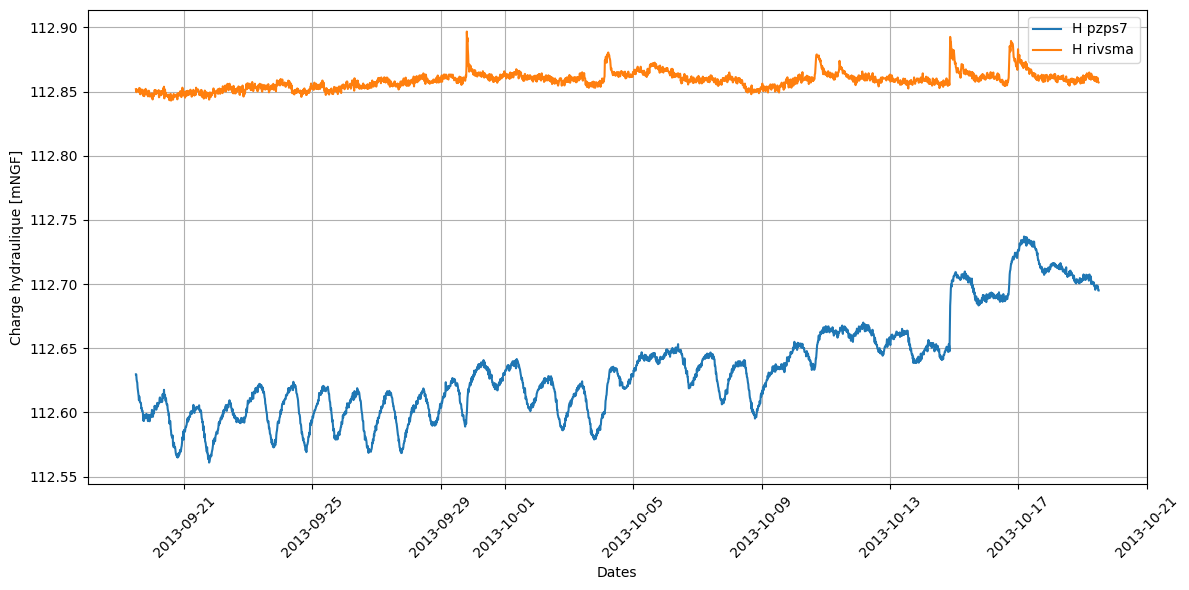

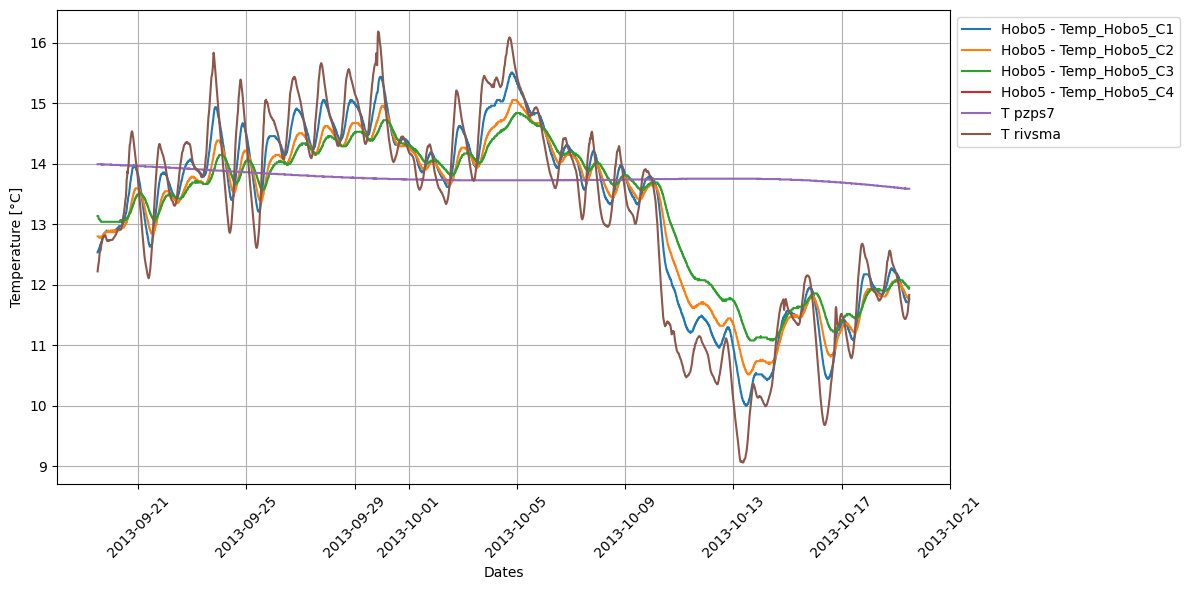

In [3]:
from src.src_python.Plot import plot_obs_station
start_date = pd.to_datetime(date_simul_bg)
end_date = start_date + pd.Timedelta(days=nb_day)
print("start_date",start_date)
print("end_date",end_date)
plot_obs_station(Station,obs_dir,start_date=start_date,end_date=end_date)

# zone of hydrofacies

Chemin du fichier de nivellement CSV : /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/IntB/IntB.csv


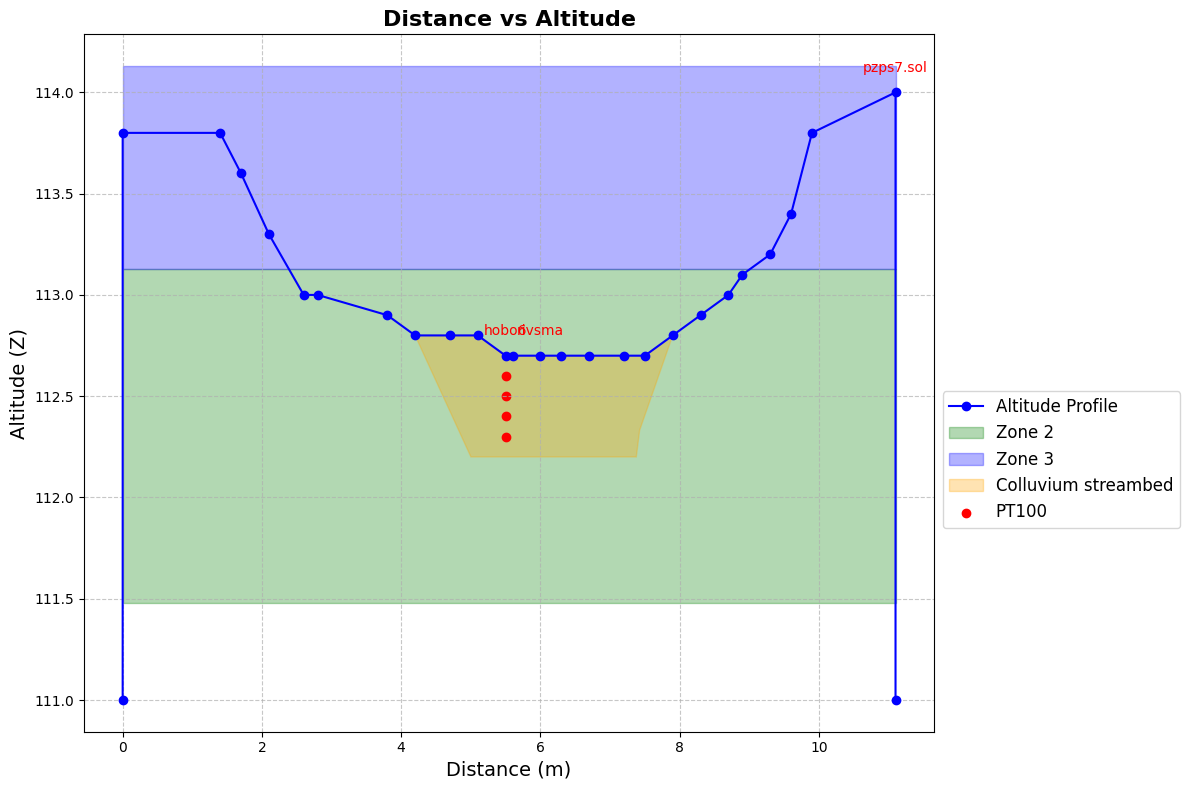

In [4]:
# reading the data georef
distance_altitude_table,pt100_coord= process_distance_altitude(desc_dir, Station, mesh_dir, altitude_min, Rive_D,dz_pt100=dz_pt100,dz_pt100first=dz_pt100first)    


# definition des zones zones
#zone 1  Green clays
# zone 2  Millstone block  xmin=-1 zmin=-3.8 xmax=10 ymin=1
rect_2 = np.array([
    [0, 113.13],
    [11.1, 113.13],
    [11.1, 111.48],
    [0, 111.48]
])
# limon loam
rect_3 = np.array([
    [0, 114.13], 
    [11.1, 114.13],
    [11.1,113.13],
    [0, 113.13]])

# zone 4  zh streambed colluvial
poly_4= np.array([
    [7.9, 112.8],
    [7.5, 112.7],
    [7.2, 112.7],
    [6.7, 112.7],
    [6.3, 112.7],
    [6, 112.7],
    [5.6, 112.7],
    [5.5, 112.7],
    [5.1, 112.8],
    [4.7, 112.8],
    [4.2, 112.8],
    [5.00214, 112.2],
    [5.46789, 112.2],
    [7.37692, 112.2],
    [7.42475, 112.33166]
])

# 
#    
# plot des données
if plot:
    

    # Configure the plot
    plt.figure(figsize=(12, 8))
    plt.plot(
        distance_altitude_table["Distance (m)"],
        distance_altitude_table["Altitude (Z)"],
        marker='o',
        # add name distance_altitude_table["Instrument"] if not NA
        linestyle='-',
        color='blue',
        label='Altitude Profile'
    )

    # Ajouter les noms des instruments au-dessus des points si ce n'est pas "NA"
    for i, instrument in enumerate(distance_altitude_table["Instrument"]):
        if instrument != "NA" and not pd.isna(instrument):
            plt.text(
                distance_altitude_table["Distance (m)"][i],
                distance_altitude_table["Altitude (Z)"][i] + 0.1,  # Décalage vertical pour éviter de chevaucher le point
                instrument,
                fontsize=10,
                color='red',
                ha='center'
            )
    # Tracer les zones rectangulaires xmin ymin and xmax ymax

    plt.fill(rect_2[:, 0], rect_2[:, 1], color='green', alpha=0.3, label='Zone 2')
    plt.fill(rect_3[:, 0], rect_3[:, 1], color='blue', alpha=0.3, label='Zone 3')
    plt.fill(poly_4[:, 0], poly_4[:, 1], color='orange', alpha=0.3, label='Colluvium streambed')



# Tracer les capteurs de température PT100
    if not pt100_coord.empty:
        pt100_label_added = False  # Variable pour suivre si le label "PT100" a été ajouté
        for i in range(len(pt100_coord)):
            plt.scatter(
                pt100_coord["Distance (m)"][i],
                pt100_coord["Altitude (Z)"][i],
                color='red',
                label="PT100" if not pt100_label_added else None  # Ajouter le label uniquement une fois
            )
            pt100_label_added = True  # Marquer que le label a été ajouté
    # Add titles and labels    # Initialize the neighbors as -99 (no neighbor)
    # The neighbors are stored in the ivois DataFrame
    plt.title("Distance vs Altitude", fontsize=16, fontweight='bold')
    plt.xlabel("Distance (m)", fontsize=14)
    plt.ylabel("Altitude (Z)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
 # Ajouter la légende en dehors de la figure, à droite
    plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.tight_layout()
    plt.show()
#     





In [5]:
pt100_coord

,hobo,pt100,Distance (m),Altitude (Z)
0,hobo6,1,5.5,112.6
1,hobo6,2,5.5,112.5
2,hobo6,3,5.5,112.4
3,hobo6,4,5.5,112.3


# Read the observation data

This section focuses on reading and processing the observation data for the simulation. The data includes temperature and hydraulic head measurements from various sensors (e.g., PT100, Hobo) located at different positions in the domain. The processed data will be used as input for the simulation and validation of the model.


In [6]:

all_data, hmax,hmin,hqt95=process_obs_RIV2D(Station, obs_dir, date_simul_bg, nb_day, desc_station, pt100_coord)


Start date: 2013-09-19 12:00:00 End date: 2013-10-19 12:00:00
Processing sensor type: pzps7
Processing sensor type: Hobo5


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:124: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: rivsma


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:124: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


# Build the model
## Build the mesh

The mesh is constructed with a rectangular domain, ensuring a structured grid for the simulation. The domain is divided into regions with varying resolutions to capture the necessary details for the model.

In [7]:

## altitude min du maillage
x_hoboRG=5.5
x_hoboRD=6
z_hoboRG=112.7
z_hoboRD=112.7
x_RG=4.5
x_RD=6.5
z_riv=112.8
v_bot=112.2
dx_precis=0.10
dx_grossier=0.25
dz_grossier=0.25
dz_precis=0.05
dx_hobo=0.05
 # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD-x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
max_x=distance_altitude_table['Distance (m)'].max()
min_x=distance_altitude_table['Distance (m)'].min()
max_z=distance_altitude_table['Altitude (Z)'].max()
# Calcul des subdivisions en x pour les regions de gauche 1, 4 et 7
length_x_gauche = x_RG - min_x
num_div_x_gauche = max(2, math.ceil(length_x_gauche / dx_grossier))

        # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD- x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
# Calcul des subdivisions en x pour les regions droite 3, 6 et 8
length_x_droite = max_x - x_RD
num_div_x_droite = max(2, math.ceil(length_x_droite / dx_grossier))

        # Calcul des subdivisions en z pour les regions haute 7 et 8
num_div_z_haut = max(2, math.ceil((max_z - z_riv) / dz_grossier))
        # Ensure the number of subdivisvalue_zone_parameter.to_csv(os.path.join(sim_dir, "E_zone_parameters.dat"), sep=' ', header=False, index=False)ions is an integer by adjusting the step size
if (max_z - z_riv) % dz_grossier != 0.1:
    num_div_z_haut = max(2, round((max_z - z_riv) / dz_grossier))
        
        # Calcul des subdivisions en z pour les regions centre 4, 5 et 6
num_div_z_centre = max(2, math.ceil((z_riv - v_bot) / dz_precis))

        # Calcul des subdivisions en z pour les regions bas 1,2 et 3
num_div_z_bas = max(2, math.ceil((v_bot - altitude_min)/dz_grossier))

print(f"Subdivisions calculées :\n"
            f"  - Gauche : {num_div_x_gauche} subdivisions\n"
            f" - dx gauche : {length_x_gauche / num_div_x_gauche:.2f} m\n"
            f"  - Centre : {num_div_x_centre} subdivisions\n"
            f" - dx centre : {length_x_centre / num_div_x_centre:.2f} m\n"
            f"  - Droite : {num_div_x_droite} subdivisions\n"
            f" - dx droite : {length_x_droite / num_div_x_droite:.2f} m\n"
            f"  - Haut : {num_div_z_haut} subdivisions\n"
            f" - dz haut : {(max_z - z_riv) / num_div_z_haut:.2f} m\n"
            f"  - Centre : {num_div_z_centre} subdivisions\n"
            f" - dz centre : {(z_riv - v_bot) / num_div_z_centre:.2f} m\n"
            f"  - Bas : {num_div_z_bas} subdivisions\n"
            f" - dz bas : {(v_bot - altitude_min) / num_div_z_bas:.2f} m\n")

Subdivisions calculées :
  - Gauche : 18 subdivisions
 - dx gauche : 0.25 m
  - Centre : 20 subdivisions
 - dx centre : 0.10 m
  - Droite : 19 subdivisions
 - dx droite : 0.24 m
  - Haut : 5 subdivisions
 - dz haut : 0.24 m
  - Centre : 12 subdivisions
 - dz centre : 0.05 m
  - Bas : 5 subdivisions
 - dz bas : 0.24 m



In [8]:
if meshplot:
    # Appel de la fonction
    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    generate_mesh_8_region(distance_altitude_table, output_mesh_path,v_bot=v_bot,x_RG =x_RG, x_RD = x_RD,z_riv=z_riv, 
                           dx_grossier=dx_grossier, dx_precis = dx_precis,x_hobo_1 =x_hoboRG, z_hobo_1=z_hoboRG,x_hobo_2 = x_hoboRD,z_hobo_2=z_hoboRD, dx_hobo=dx_hobo, 
                           dz_grossier=dz_grossier, dz_precis=dz_precis,dz_hobo1=dz_pt100first,dz_hobo=dz_pt100,mesh_dimension=2)

    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    remove_elements_above_curve_all_entities(distance_altitude_table, output_mesh_path, ajout='_remove_all_entities', retirer='')
    plot_gmsh_mesh(output_mesh_path.replace(".msh", "_remove_all_entities.msh")) # Modification du nom car on applique 2 fois la fct remove elements 




Génération du maillage structuré avec Gmsh...
hobo 6.0 5.6 0.1 -49.99999999999999
Subdivisions calculées :
  - Gauche : 18 subdivisions
 - dx gauche : 0.25 m
  - Centre : 20 subdivisions
 - dx centre : 0.10 m
  - Droite : 19 subdivisions
 - dx droite : 0.24 m
  - Haut : 5 subdivisions
 - dz haut : 0.24 m
  - Centre : 12 subdivisions
 - dz centre : 0.05 m
  - Bas : 5 subdivisions
 - dz bas : 0.24 m

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    

Widget(value='<iframe src="http://localhost:41817/index.html?ui=P_0x7da8c9125660_0&reconnect=auto" class="pyvi…

## Creation of the Coordinate File

This section focuses on generating the coordinate file for the mesh. The file contains the x and z coordinates of the mesh centers, which are essential for defining the spatial structure of the simulation domain. The coordinates are extracted from the mesh data and saved in a format compatible with the simulation software.

In [9]:

from src.src_gmsh import mesh_generator
importlib.reload(mesh_generator)

from src.src_gmsh.mesh_generator import readGmsh
fName = os.path.join(mesh_dir, "rectangular_mesh_remove_all_entities.msh")
# rename to pt100_coord with x and z
pt100_coord.rename(columns={"Distance (m)": "x", "Altitude (Z)": "z"}, inplace=True)

centres,nb_mesh,def_maille = readGmsh(fName, precision=3)
# write the coordinates in a file witout the header
centres.to_csv(os.path.join(sim_dir, "E_coordonnee.dat"), sep=' ', header=False, index=False)
def_maille.to_csv(os.path.join(sim_dir, "E_def_maille.dat"), sep=' ', header=False, index=False)

# write index with the first =1 in the first column of the centres dataframe
centres['index'] = np.arange(1, len(centres) + 1)




### Plot the Center of Cells

This section visualizes the center of each mesh cell in the domain. The plot provides a clear representation of the spatial distribution of the mesh centers, which is essential for understanding the structure of the simulation grid.

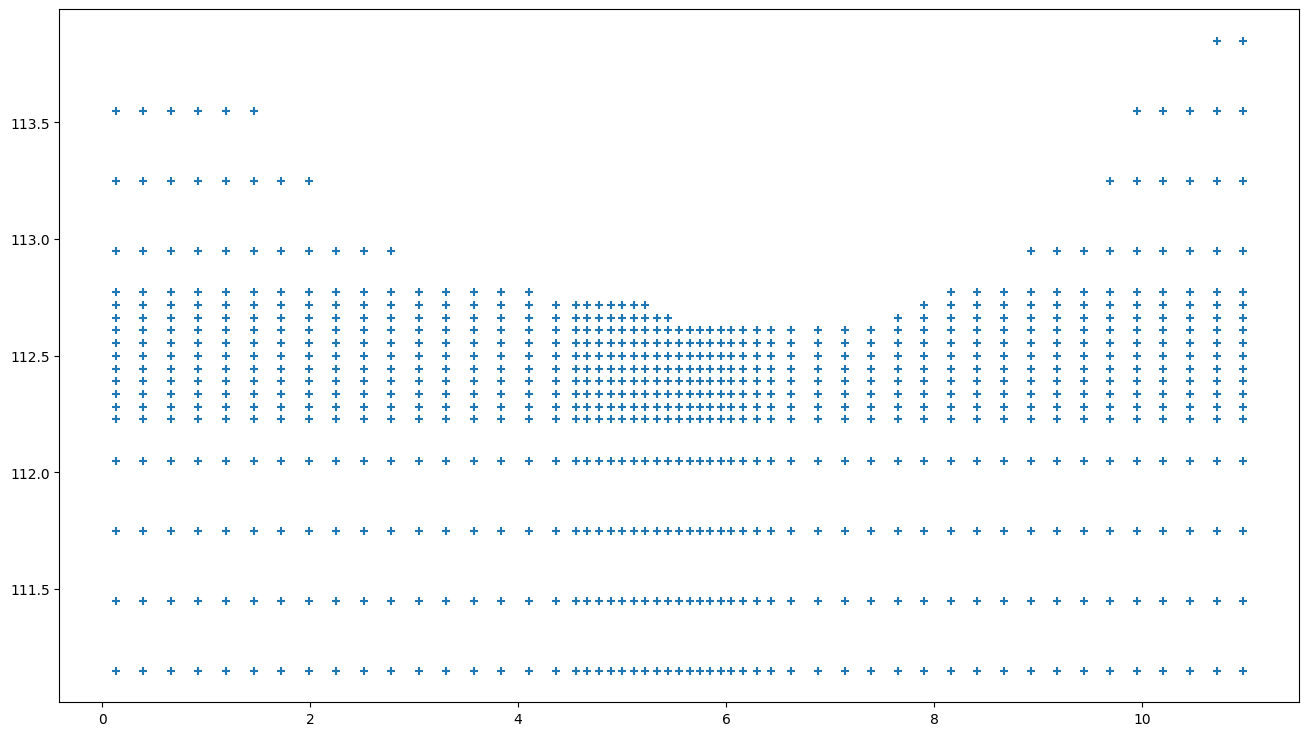

In [10]:
# interactive corrdinates on the plot
x = centres['x']
z = centres['z']
fig, ax = plt.subplots(figsize = (16,9))

ax.scatter(x,z,marker="+") # Trace le centre de chaque mailles
plt.show()

## Index of the Temperature Sensors
The index corresponds to Ginette's `n_maille` values, which are saved for each temperature sensor.

In [11]:
# Find the index of the mesh center nearest to each PT100 coordinate and add the corresponding information to pt100_coord
for i in range(len(pt100_coord)):
    # Calculate the index of the nearest mesh center to the current PT100 coordinate
    index = ((centres['x'] - pt100_coord["x"][i])**2 + (centres['z'] - pt100_coord["z"][i])**2).idxmin()
    
    # Add the index of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'index'] = centres.loc[index, 'index']
    
    # Calculate and add the distance between the PT100 coordinate and the nearest mesh center
    pt100_coord.loc[i, 'distance'] = np.sqrt((centres['x'][index] - pt100_coord["x"][i])**2 + (centres['z'][index] - pt100_coord["z"][i])**2)
    
    # Add the x and z coordinates of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'xmaille'] = centres.loc[index, 'x']
    pt100_coord.loc[i, 'zmaille'] = centres.loc[index, 'z']

# Convert the 'index' column to integers and store it in a new column 'n_maille'
pt100_coord['n_maille'] = pt100_coord['index'].astype(int)

# Display the first 8 rows of the updated pt100_coord DataFrame
print(pt100_coord.head(8))

    hobo  pt100    x      z  index  distance  xmaille  zmaille  n_maille
0  hobo6      1  5.5  112.6    404  0.050804     5.55  112.609       404
1  hobo6      2  5.5  112.5    406  0.050000     5.55  112.500       406
2  hobo6      3  5.5  112.4    408  0.050804     5.55  112.391       408
3  hobo6      4  5.5  112.3    410  0.053141     5.55  112.282       410


### Plot the Figure for Verification

This section visualizes the mesh centers and their indices to verify the spatial structure of the simulation grid. The plot provides a clear representation of the mesh layout, helping to ensure that the mesh is correctly defined and aligned with the simulation requirements.

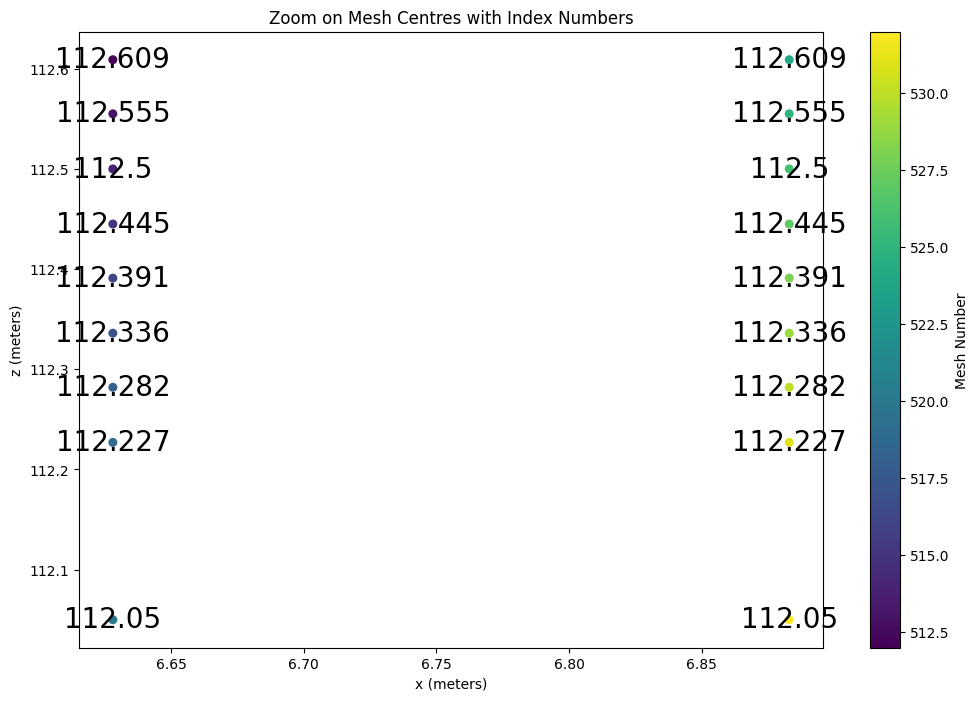

In [12]:

# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 6.6) & (centres['x'] < 7) &
    (centres['z'] > 112.) & (centres['z'] < 114.6)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['z']), fontsize=20, color='black', ha='center', va='center')

# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

## Creation of Dimensions
- `nb_col`: Number of columns in the mesh grid.
- `nb_row`: Number of rows in the mesh grid.

Create the files `E_colonne.dat` and `E_row.dat` to store the column and row indices of the mesh grid.

In [13]:
# Call the function to calculate the number of columns and rows in the mesh grid
# This function reads the mesh data and determines the grid dimensions
nb_col, nb_row = coord_to_row_column(script_dir)

Found 19 distinct columns; max assigned column = 53
Found 53 distinct rows;    max assigned row    = 19


## Build the Neighbor Table
### and the Index of the Cell at the Right and Left Side of the Simulated Domain
- **col1**: Index of the right neighbor cell.
- **col2**: Index of the left neighbor cell.
- **col3**: Index of the top neighbor cell.
- **col4**: Index of the bottom neighbor cell.

In [14]:
ivois = voisin_mesh(script_dir)
RG, RD = maille_limite(script_dir)

Neighbors saved to E_voisins.dat.


### Plot to check the index

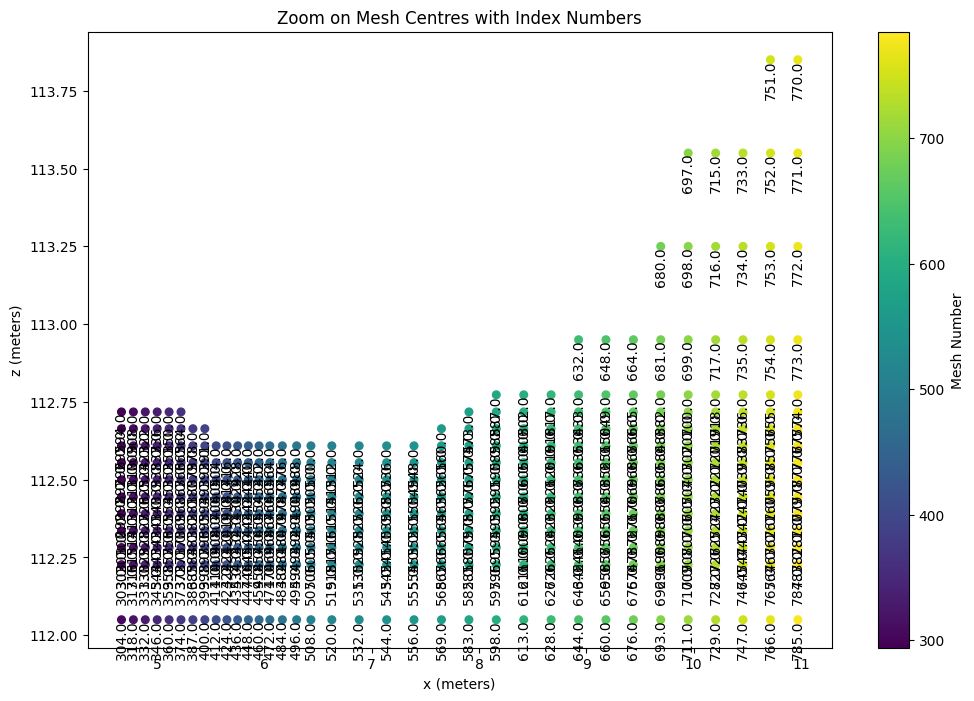

In [15]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.6) & (centres['x'] < 12.4) &
    (centres['z'] > 112) & (centres['z'] < 114)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()


# River Identification

In [16]:
river=id_mesh_river(script_dir,hmax,hmin,xRG,xRD)
id_river_min,id_river_max=river


# verif id river

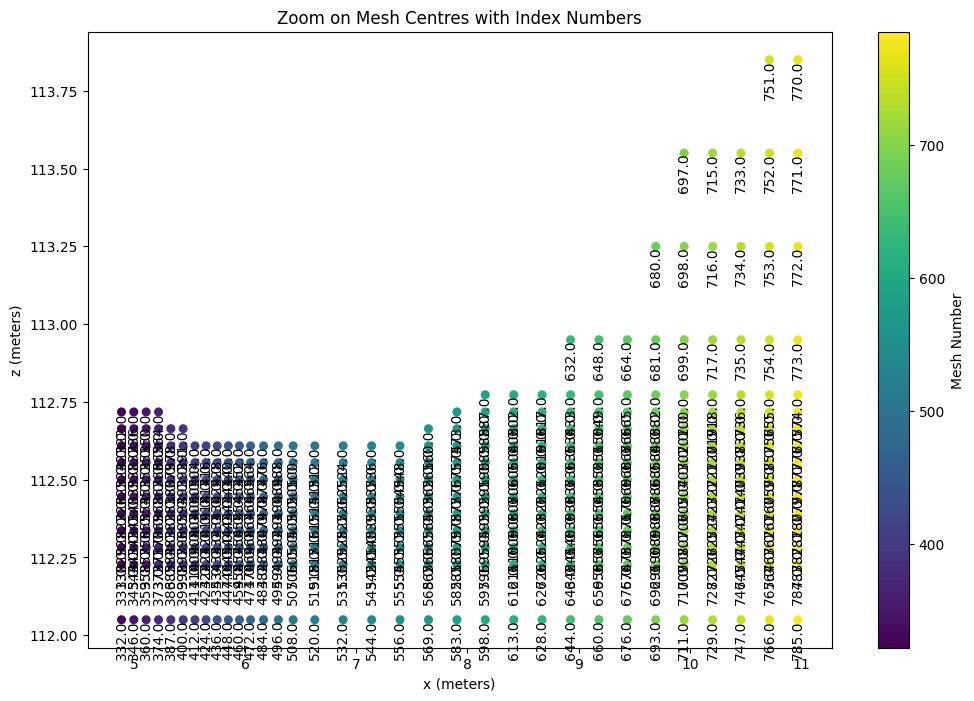

In [17]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.8) & (centres['x'] < 11.1) &
    (centres['z'] > 112) & (centres['z'] < 114)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

# Creation of E_zone.dat
* E_zone.dat: Zone number for each mesh cell, where each line corresponds to one integer.

    '''
    Function to populate the E_zone.dat file, which is required for Ginette. 
    This function uses the mesh data (E_coordonnee.dat file) and a DataFrame containing polygons organized by their respective zones. 
    The function checks whether the center of each mesh cell is located within a polygon. 
    Once the zone of the mesh cell is identified, it is added to a list, which is then written to the E_zone.dat file at the end of the function.

    Inputs:
    - polygons_by_zone (DataFrame): DataFrame containing the polygons that define the different zones of the mesh. 
      An example of creating polygons_by_zone is provided in the code.
    - default_zone (int): Default zone (default = 1) assigned to points not contained in any polygon. 
      This avoids the need to define all polygons in polygons_by_zone.
    '''

Zones present in E_zone.dat: {1, 2, 3, 4}
All expected zones are present in E_zone.dat.


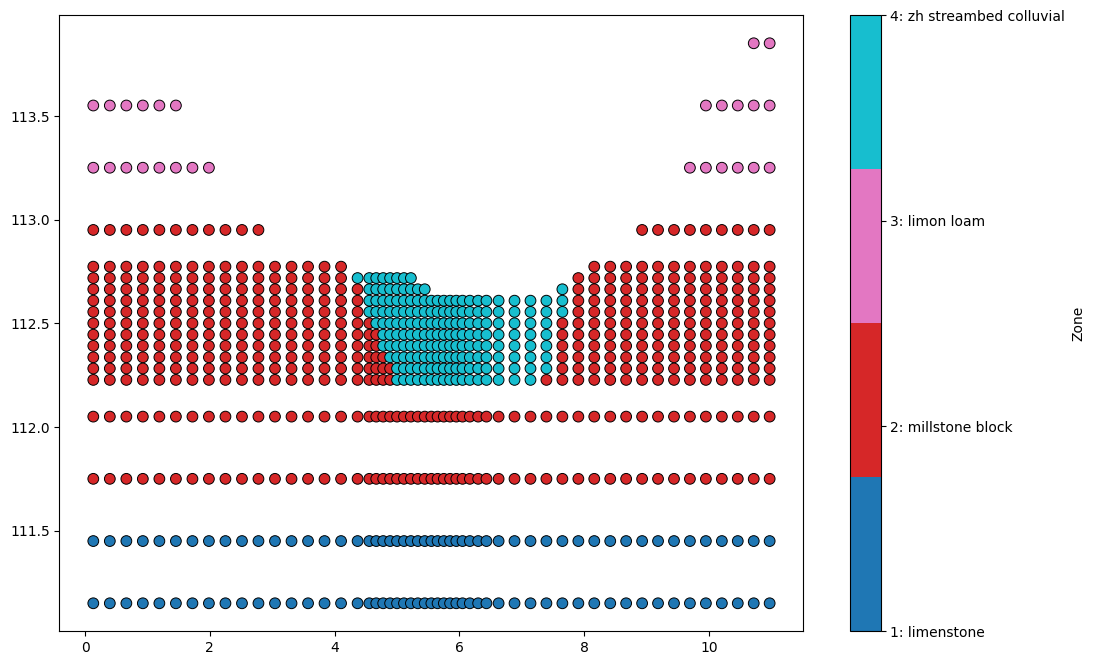

In [18]:
from src.src_gmsh.mesh_generator import creation_E_zone
from shapely.geometry import Point
import numpy as np
importlib.reload(mesh_generator)
# Define the polygons for each zone
# Ensure the order of polygons in the dictionary matches the zone numbers
# Get all zone numbers from polygons_by_zone, sorted by descending zone number (priority: higher zone number first)
polygons_by_zone = {
        4: [Polygon(poly_4)],  # Zone 3
        3: [Polygon(rect_3)],  # Zone 2
        2: [Polygon(rect_2)],  # Zone 1
}

creation_E_zone(sim_dir,polygons_by_zone,default_zone=1)


# read the E_zone.dat file
zone = pd.read_csv(os.path.join(sim_dir, "E_zone.dat"), sep=' ', header=None)
# merge with coordinates
zone = pd.merge(centres, zone, left_index=True, right_index=True)
# plot color by zone
plt.figure(figsize=(12, 8))
plt.scatter(
        zone['x'], zone['z'],
        c=zone[0],
        cmap=plt.get_cmap('tab10', nb_zone),  # Use a colormap with nb_zone discrete colors
        s=60, edgecolor='k', linewidth=0.7, vmin=1, vmax=nb_zone
)
# add legend zone =1 : green clay, zone =2 : millstone block, zone =3 : limon loam, zone =4 : zh streambed colluvial
# Create a colorbar with custom tick labels for zones
cbar = plt.colorbar(ticks=[1, 2, 3, 4])
cbar.set_label('Zone')
cbar.set_ticklabels([
    '1: limenstone',
    '2: millstone block',
    '3: limon loam',
    '4: zh streambed colluvial',
])


# Initial Parameters for Each Hydrofacies Zone

This section defines the physical and thermal parameters for each hydrofacies zone used in the simulation.

---

## Parameter Definitions

| Symbol | Name                                 | Unit                | Description                                 |
|--------|--------------------------------------|---------------------|---------------------------------------------|
| **k**  | Intrinsic permeability               | m²                  | Controls groundwater flow                   |
| **n**  | Porosity                             | (dimensionless, [-])| Fraction of void space                      |
| **l**  | Thermal conductivity of the solid    | W·m⁻¹·K⁻¹           | Heat transfer ability of the solid matrix   |
| **cₛ** | Specific heat capacity of the solid  | J·kg⁻¹·K⁻¹          | Heat storage capacity of the solid matrix   |
| **r**  | Density of the solid                 | kg·m⁻³              | Mass per unit volume of the solid matrix    |

---

## Heat Capacity Calculation in Ginette

The volumetric heat capacity ($ c_{pm} $) is computed as:

$$
c_{pm} = c_w \cdot \rho_w \cdot n \cdot \text{sat} + c_s \cdot \rho_s \cdot (1-n) + c_a \cdot \rho_a \cdot n \cdot (1-\text{sat})
$$

Where:

- $ c_w $: Specific heat capacity of water (J·kg⁻¹·K⁻¹)
- $ \rho_w $: Density of water (kg·m⁻³)
- $ n $: Porosity (dimensionless)
- $ \text{sat} $: Saturation (dimensionless)
- $ c_s $: Specific heat capacity of the solid (J·kg⁻¹·K⁻¹)
- $ \rho_s $: Density of the solid (kg·m⁻³)
- $ c_a $: Specific heat capacity of air (J·kg⁻¹·K⁻¹)
- $ \rho_a $: Density of air (kg·m⁻³)

> **Note:**  
> - The value of $ \rho_s $ (solid density) is typically kept constant.  
> - Avoid calibrating both $ \rho_s $ and $ c_s $ simultaneously to prevent non-uniqueness in parameter estimation.

---

## Effective Thermal Conductivity

The effective thermal conductivity of the aquifer (water + solid) is:

$$
\lambda_{\text{aquifer}} = \lambda_w \cdot n + \lambda_s \cdot (1-n)
$$

- $ \lambda_w $: Thermal conductivity of water (W·m⁻¹·K⁻¹), typically $ 0.598 \times 10^{-3} $ W·m⁻¹·K⁻¹
- $ \lambda_s $: Thermal conductivity of the solid (W·m⁻¹·K⁻¹)

---

All parameters are organized and transformed for clarity and direct use in the simulation workflow.  
Refer to the next code cell for the actual parameter values used for each hydrofacies zone.


## Transform Parameters for Better Readability

This section focuses on transforming the parameters to improve their readability and usability. For example, permeability values are converted to logarithmic scale for easier interpretation, and other parameters are organized into a structured format for better clarity.

In [19]:
# definition des zones zones
#zone 1 
permeabilite_1=  3.084000000000000e-08
conductivite_1  = 1.496814970000000
porosity_1 = 0.1013930100000000
#zone 2
permeabilite_2 = 2.129000000000000e-06 
conductivite_2= 3.571221300000000
porosity_2= 0.3118701000000000

# zone 3
permeabilite_3 =  2.023000000000000e-06
conductivite_3 = 1.925552800000000
porosity_3 =   0.2612479000000000

# zone 4
permeabilite_4=5.200000000000000e-06
conductivite_4 = 2.716900000000000
porosity_4  =     0.2647000000000000


capacite_aquifere  =   2.5e+6 #cpm

# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity = capacite calorifique massique du solide
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
c_w=4185  #D+00	       m2/s2/C
r_w=1000  #kg/m3
# solid density r=val_r

# in ginette we need c_s and r
density=850 # r
c_s=(capacite_aquifere-c_w*r_w*porosity_4)/((1-porosity_4)*density)
print('c_s',c_s)


  
#         alanda_aquifer(eau+solide) = (alanda_w*n) + alandas*(1 -n))
#          alandae=0598E-03


# all perameabilities change in m2 and just the log
# loop nb_zone
for i in range(1, nb_zone + 1):
    # transform the permeability in m2 
    # name permeabilite_1 to permeabilite_5
    # get the name of the variable
    var_name = f"permeabilite_{i}"
    # get the value of the variable
    value = locals()[var_name]
    # transform the value in m2
    value = value * 1e-7
    # transform the value in log10
    value = np.log10(value)
    # set the value in the variable
    locals()[var_name] = value

#dataframe name column with parameters
value_zone_parameter=pd.DataFrame(columns=parameters)
value_zone_parameter['k'] = [permeabilite_1, permeabilite_2, permeabilite_3, permeabilite_4]
value_zone_parameter['n'] = [porosity_1, porosity_2, porosity_3, porosity_4]
value_zone_parameter['l'] = [conductivite_1,conductivite_2,conductivite_3,conductivite_4]
value_zone_parameter['cs'] = [c_s, c_s, c_s, c_s]
value_zone_parameter['r'] = [density, density, density, density]

importlib.reload(Direct_model)
generate_zone_parameters_undef(nb_zone,value_zone_parameter=value_zone_parameter,parameters=parameters)



c_s 2227.550979592163


In [20]:
all_data

,dates,H_RD,T_RD,Temp_Hobo5_1,Temp_Hobo5_2,Temp_Hobo5_3,Temp_Hobo5_4,H_RIV,T_RIV,H_RG,T_RG
57022,2013-09-19 12:00:00,112.62967,13.993,12.534,12.799,13.137,12.251337,112.85192,12.220,112.62967,13.993
57023,2013-09-19 12:15:00,112.62967,13.993,12.534,12.799,13.137,12.251577,112.84958,12.273,112.62967,13.993
57024,2013-09-19 12:30:00,112.62583,13.993,12.558,12.799,13.137,12.251817,112.84983,12.307,112.62583,13.993
57025,2013-09-19 12:45:00,112.62408,13.993,12.558,12.799,13.112,12.252058,112.85158,12.340,112.62408,13.993
57026,2013-09-19 13:00:00,112.62325,13.993,12.582,12.799,13.088,12.252298,112.85133,12.360,112.62325,13.993
...,...,...,...,...,...,...,...,...,...,...,...
59898,2013-10-19 11:00:00,112.69800,13.587,11.710,11.783,11.953,12.942683,112.85842,11.610,112.69800,13.587
59899,2013-10-19 11:15:00,112.69858,13.587,11.710,11.783,11.953,12.942923,112.86075,11.663,112.69858,13.587
59900,2013-10-19 11:30:00,112.69800,13.587,11.734,11.759,11.953,12.943163,112.85842,11.703,112.69800,13.587
59901,2013-10-19 11:45:00,112.69500,13.587,11.734,11.759,11.929,12.943404,112.85775,11.763,112.69500,13.587


## permanant state

In [21]:
setup_ginette_perm_2D(pt100_coord,nb_mesh,nb_col,nb_row,nb_day=nb_day,dt=dt)
initial_conditions_perm_2D()
    # If 'H_RD' or 'H_RG' do not exist in all_data, copy the value from the other if available
if 'H_RD' not in all_data.columns:
    all_data['H_RD'] = all_data['H_RG']
if 'H_RG' not in all_data.columns:
    all_data['H_RG'] = all_data['H_RD']
if 'T_RD' not in all_data.columns:
    all_data['T_RD'] = all_data['T_RG']
if 'T_RG' not in all_data.columns:
    all_data['T_RG'] = all_data['T_RD']
boundary_conditions_2D(all_data,dt)
boundary_conditions_perm_2D(all_data,dt)
boundary_conditions_perm_2D_tdirect()


# Run the direct model

In [22]:
from src.src_python.Direct_model import run_direct_model_2D
run_direct_model_2D(dir_ginette)


Running Ginette (steady-state)...
 pb coordonnee def maille z
 maille:           6 voisin haut:           5
 difference largeur voisine haute=   5.5000000000000000E-002
 difference coordonnee voisine  haute=   5.4000000000002046E-002
 z coordonnee maille=   112.66400000000000     
 z coordonnee maille voisine=   112.71800000000000     
 dz thick maille=   5.5000000000000000E-002
 dz thick voisine=   5.5000000000000000E-002
 Ratio voisine  haute=  0.98181818181821900     
Step 2 (steady-state Ginette) executed in 1.67 seconds.
Running Ginette (transient)...
 pb coordonnee def maille z
 maille:           6 voisin haut:           5
 difference largeur voisine haute=   5.5000000000000000E-002
 difference coordonnee voisine  haute=   5.4000000000002046E-002
 z coordonnee maille=   112.66400000000000     
 z coordonnee maille voisine=   112.71800000000000     
 dz thick maille=   5.5000000000000000E-002
 dz thick voisine=   5.5000000000000000E-002
 Ratio voisine  haute=  0.98181818181821900 

In [23]:
obs_temp=all_data
# read the results
sim_temp = pd.read_csv("S_temp_PT100_t.dat", sep='\s+', header=0,names=["Time", "Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"])
      # Ajouter une colonne de dates en utilisant la date de début de simulation
date_simul_bg = pd.to_datetime(date_simul_bg)
sim_temp['dates'] = date_simul_bg + pd.to_timedelta(sim_temp['Time'], unit='s')
obs_temp.head(8)
# remet les index à 0
obs_temp.reset_index(drop=True, inplace=True)
obs_temp.head(8)


,dates,H_RD,T_RD,Temp_Hobo5_1,Temp_Hobo5_2,Temp_Hobo5_3,Temp_Hobo5_4,H_RIV,T_RIV,H_RG,T_RG
0,2013-09-19 12:00:00,112.62967,13.993,12.534,12.799,13.137,12.251337,112.85192,12.220,112.62967,13.993
1,2013-09-19 12:15:00,112.62967,13.993,12.534,12.799,13.137,12.251577,112.84958,12.273,112.62967,13.993
2,2013-09-19 12:30:00,112.62583,13.993,12.558,12.799,13.137,12.251817,112.84983,12.307,112.62583,13.993
3,2013-09-19 12:45:00,112.62408,13.993,12.558,12.799,13.112,12.252058,112.85158,12.340,112.62408,13.993
4,2013-09-19 13:00:00,112.62325,13.993,12.582,12.799,13.088,12.252298,112.85133,12.360,112.62325,13.993
5,2013-09-19 13:15:00,112.61917,13.993,12.582,12.799,13.088,12.252538,112.85133,12.400,112.61917,13.993
6,2013-09-19 13:30:00,112.61683,13.993,12.606,12.775,13.088,12.252779,112.85133,12.467,112.61683,13.993
7,2013-09-19 13:45:00,112.61508,13.993,12.606,12.775,13.088,12.253019,112.85133,12.510,112.61508,13.993


In [24]:

sim_temp,obs_temp=remove_first_two_days(sim_temp,obs_temp,date_simul_bg)

print(obs_temp.head(8))

                  dates       H_RD    T_RD  Temp_Hobo5_1  Temp_Hobo5_2  \
192 2013-09-21 12:00:00  112.60025  13.953        12.654        12.847   
193 2013-09-21 12:15:00  112.60025  13.953        12.678        12.847   
194 2013-09-21 12:30:00  112.60175  13.953        12.703        12.847   
195 2013-09-21 12:45:00  112.60083  13.947        12.751        12.847   
196 2013-09-21 13:00:00  112.59817  13.953        12.775        12.847   
197 2013-09-21 13:15:00  112.59492  13.953        12.799        12.847   
198 2013-09-21 13:30:00  112.59467  13.953        12.847        12.847   
199 2013-09-21 13:45:00  112.59208  13.947        12.871        12.847   

     Temp_Hobo5_3  Temp_Hobo5_4      H_RIV   T_RIV       H_RG    T_RG  \
192        13.137     12.297490  112.84758  12.570  112.60025  13.953   
193        13.112     12.297731  112.84933  12.630  112.60025  13.953   
194        13.112     12.297971  112.85083  12.703  112.60175  13.953   
195        13.112     12.298212  112.8499

# Save the observation data for the inverion script

In [25]:

col_to_save=['dates','Time','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5','Temp_6','Temp_7','Temp_8']
obs_temp_save=obs_temp[col_to_save]
obs_temp_save.head(8)
# save in "Obs_temp_PT100_t.dat"
obs_temp_save.to_csv("Obs_temp_PT100_t.dat", sep=',', header=True, index=False)


KeyError: "['Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_6', 'Temp_7', 'Temp_8'] not in index"

# Plot the comparison between obs and sim

['2016-09-21T12:00:00.000000000' '2016-09-21T12:15:00.000000000'
 '2016-09-21T12:30:00.000000000' ... '2016-10-19T11:30:00.000000000'
 '2016-10-19T11:45:00.000000000' '2016-10-19T12:00:00.000000000']


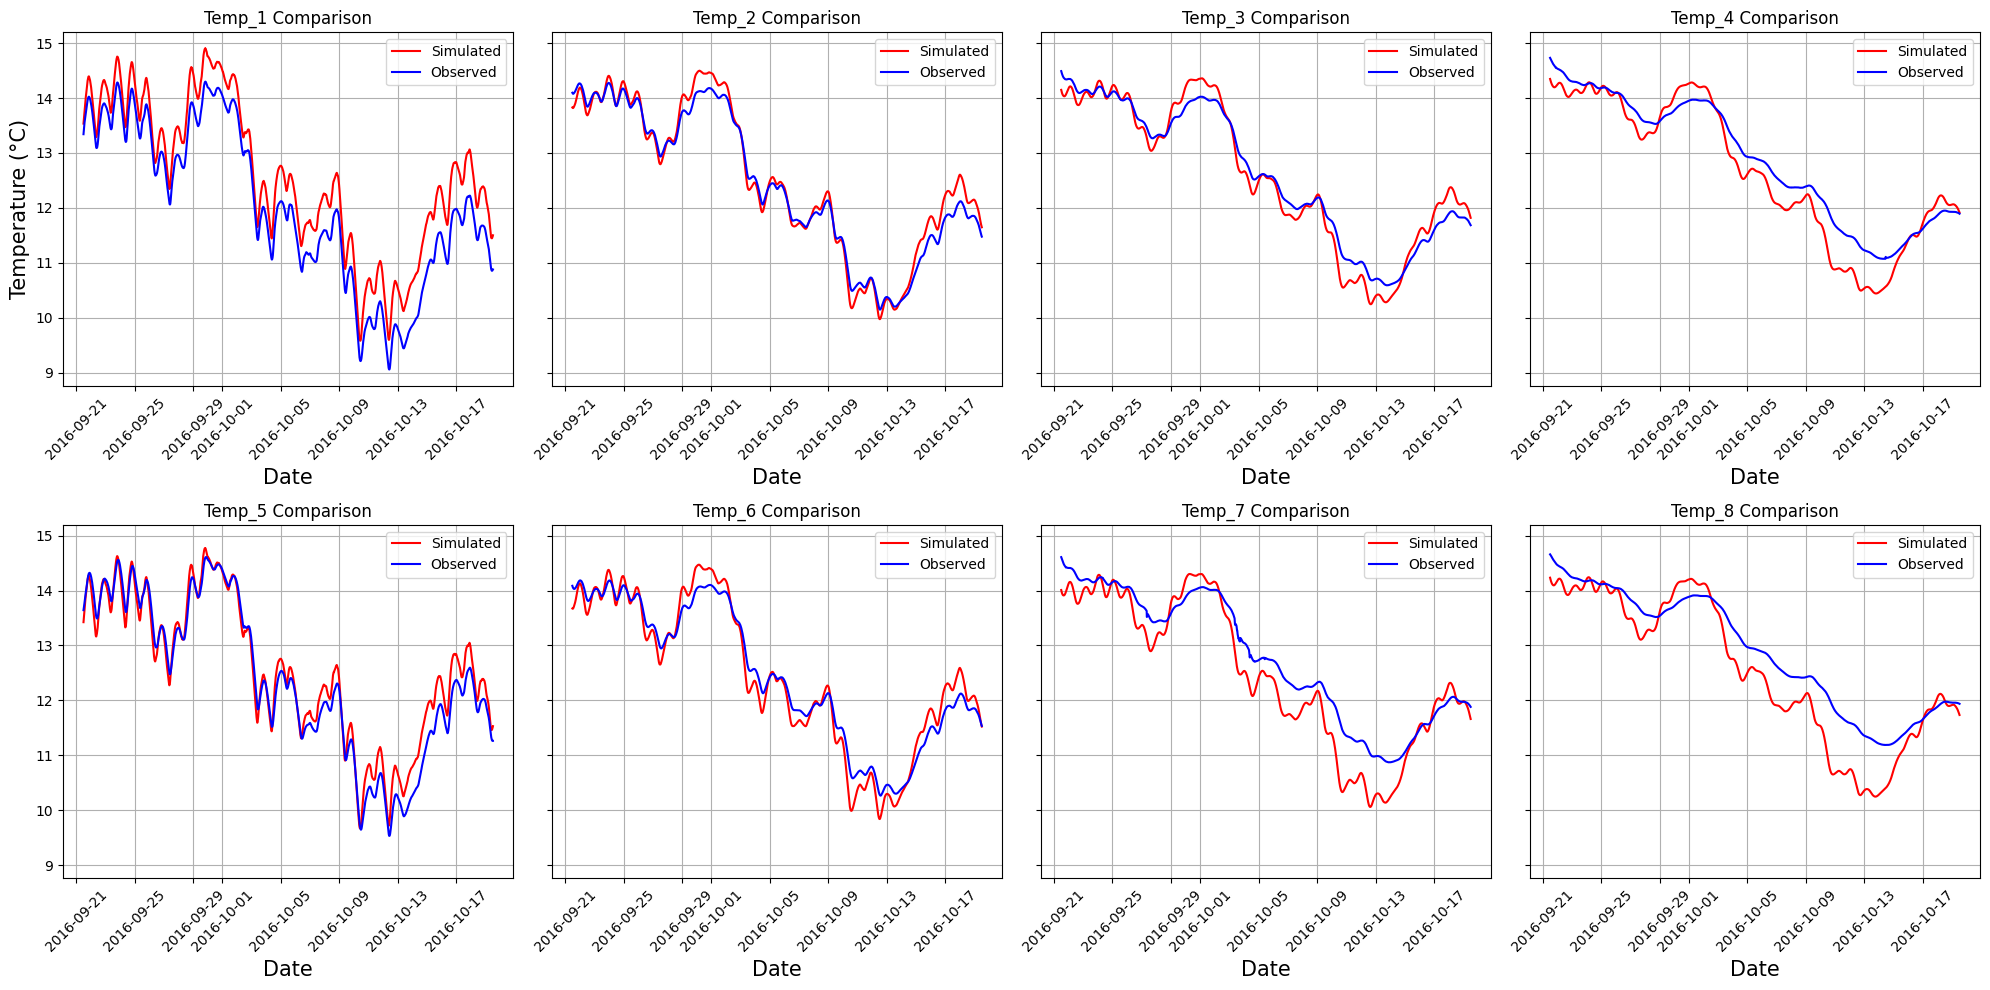

In [25]:
from src.src_python.Plot import *
importlib.reload(Plot)
temp_columns=['Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_6', 'Temp_7', 'Temp_8']
# plot the results
plot_compare_temperatures_obs_sim(
    sim_temp=sim_temp,
    obs_temp=obs_temp,
    temp_columns=temp_columns,
    fontsize=15)

# Check the size of number of lines of obs and sim

In [26]:
# Verif size of obs_temp and sim_temp
print("size obs_temp",obs_temp.shape)
print("size sim_temp",sim_temp.shape)
# compare number of rows
if obs_temp.shape[0] != sim_temp.shape[0]:
    print("Warning: The number of rows in obs_temp and sim_temp are different")

size obs_temp (2689, 16)
size sim_temp (2689, 10)


In [27]:
sigma = 0.2
Temp_vector = ["Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"]
mse_values = {}

for col in Temp_vector:
    # transform the column in vector
    prediction = sim_temp[col].values
    observation = obs_temp[col].values
    mse_values[col] = mse(prediction, observation, sigma=sigma)

mse_df = pd.DataFrame([mse_values])
print(mse_df)


         Temp_1       Temp_2       Temp_3       Temp_4       Temp_5  \
0  22007.439373  2540.071198  3815.447554  8950.145726  5623.221845   

        Temp_6        Temp_7        Temp_8  
0  4015.741901  13188.655182  18709.225103  


# Copy all files in Station directory to use for the inversion

In [28]:
import shutil
# create a directory with the name of the station
os.makedirs(os.path.join(sim_dir, Station), exist_ok=True)
# gather all files in the simulation directory
allfiles = os.listdir(sim_dir)
# iterate on all files to copy only .dat files to the Station directory
for f in allfiles:
    if f.endswith('.dat'):
        src_path = os.path.join(sim_dir, f)
        dst_path = os.path.join(sim_dir, Station, f)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)


